# Capstone

## Pune Population and Food service Data & Visualisation

#### Dependenices

In [200]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import googlemaps #geocoding library
from datetime import datetime

from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  

import geopandas as gpd# for the choropleth map
import matplotlib.pyplot as plt
print('Libraries imported.')
%matplotlib inline

Libraries imported.


## Importing and Organising Data

This data has been aquired from the Pune Municipal Corporation's web portal

In [65]:
pune = pd.read_csv('popPune.csv')
pune.drop(columns = {'Unnamed: 0'}, inplace=True) #dropping un-required Ward-Number column
pune.drop([144,73], axis=0, inplace=True) #dropping error-giving columns for ease of data processing
pune= pune.append({'Ward Office':"Camp", 'Ward Name':"Camp", 'Population':171781}, ignore_index=True) #Manual entry from seperate cenus file for Cantonment Area
pune

,Population,Ward Office,Ward Name
0,44060,Sangamwadi,Dhanori
1,25430,Sangamwadi,Vidhyanagar Lohagaon
2,22592,Sangamwadi,Tingre Pumping Station
3,24678,Sangamwadi,Kalas Vishrantwadi
4,18490,Sangamwadi,Nanasaheb Parulekar Vidhyalaya
5,26134,Sangamwadi,Yerwada Prizen Press
6,33810,Yerwada/Nagarroad,Lohagaon Vimantal
7,37947,Yerwada/Nagarroad,Kharadigaon
8,24332,Yerwada/Nagarroad,Kharadi Infotech Park
9,24433,Yerwada/Nagarroad,Sundrabai Marathe Vidhyalaya


Creating a new Dataframe with Only the Main Ward Offices and corresponding total Population

Also creating a second dataframe with the Wards Grouped together in a list by Ward Offices.

In [66]:
pune_ward_list = pune.groupby(['Ward Office'])['Ward Name'].agg(list)
pune_population = pune.groupby(['Ward Office']).agg('sum')
pune_population.reset_index(inplace = True)
pune_population

,Ward Office,Population
0,Aundh,181124
1,Bhavanipeth,177346
2,Bibvewadi,291446
3,Camp,171781
4,Dhankawadi,236648
5,Dholepatilroad,155413
6,Gholeroad,171678
7,Hadapsar,324751
8,Kasbavishrambaug,178484
9,Kothrud,209331


### Getting location data from Google's Maps Geocoding API

Create the Dataframe & Initaite the Google API

In [42]:
columns = ['Ward Name', 'Latitude', 'Longitude']

pune_LL = pd.DataFrame(columns = columns)

In [111]:
{
    "tags": [
        "remove_input",
    ]
}
gmaps = googlemaps.Client(key='')

Fill the Dataframe

In [43]:
for ward in pune['Ward Name']:
    geocode_result = gmaps.geocode(ward+", Pune")
    if(geocode_result!=[]):
        lat = geocode_result[0]["geometry"]["location"]["lat"]
        lon = geocode_result[0]["geometry"]["location"]["lng"]
    else : 
        lat = None
        lon = None
    pune_LL = pune_LL.append({'Ward Name': ward,
                            'Latitude': lat,
                            'Longitude': lon}, ignore_index=True)
print("Data Processed")

Data Processed


In [76]:
print('The dataframe has {} Ward Offices and {} Wards.'.format(
        len(df['Ward Office'].unique()),
        pune.shape[0]
    )
)
pune_LL

The dataframe has 14 Ward Offices and 144 Wards.


,Ward Name,Latitude,Longitude
0,Dhanori,18.596759,73.896851
1,Vidhyanagar Lohagaon,18.594668,73.917508
2,Tingre Pumping Station,18.576718,73.893968
3,Kalas Vishrantwadi,18.572605,73.878208
4,Nanasaheb Parulekar Vidhyalaya,18.567113,73.880916
5,Yerwada Prizen Press,18.562621,73.889375
6,Lohagaon Vimantal,18.579343,73.908917
7,Kharadigaon,18.547059,73.947004
8,Kharadi Infotech Park,18.551755,73.937697
9,Sundrabai Marathe Vidhyalaya,18.557358,73.928419


### Visualize each of the Wards on a Map using Folium

In [77]:
#get Latitiude and logitude data for Pune from Google's Maps API
address = 'Pune, Maharashtra'

geocode_result = gmaps.geocode(address)
latitude = geocode_result[0]["geometry"]["location"]["lat"]
longitude = geocode_result[0]["geometry"]["location"]["lng"]

# create map of Pune
map_Pune = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, ward_off, ward_name in zip(pune_LL['Latitude'], pune_LL['Longitude'], pune['Ward Office'], pune_LL['Ward Name']):
    label = '{}, {}'.format(ward_name, ward_off)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Pune)  
    
map_Pune

### Creating a Population Density Choropleth Map

The geojson data made avaliable has labels that are differnet to the ones used in the original CSV file.
To work around this, the json file attributes were appropriately renamed and sorted.

To make plotting simpler, the geojson files were then converted to SHP(Shape vector) files for use with GeoPandas

A region called "Camp" that does not fall under the jurisdiction of the Pune Municipal Corporation is also added.

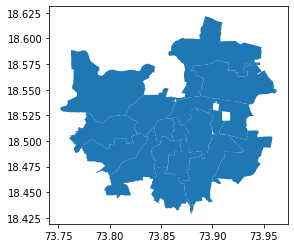

In [50]:
map_df = gpd.read_file('PuneSHP/punegeo-polygon.shp')
map_df_1 = gpd.read_file('PuneSHP/campgeo-polygon.shp')
map_df_1.rename(columns={"id":"name"})
map_df_1.loc[0,"name"]="Camp"
map_df = map_df.append(map_df_1, sort=True)
map_df.plot()

#### Combining Population and GeoPandas Dataframes

In [67]:
map_df.loc[10,"name"]="Bibvewadi" # Renaming errorneous Ward

merged = map_df.set_index('name').join(pune_population.set_index('Ward Office'))
merged.drop(columns={"id"}, inplace=True)
merged

,geometry,Population
Aundh,"POLYGON ((73.82476 18.53713, 73.82464 18.53704...",181124
Bhavanipeth,"POLYGON ((73.87321 18.50540, 73.87324 18.50537...",177346
Bibvewadi,"POLYGON ((73.85631 18.47448, 73.85626 18.47524...",291446
Camp,"POLYGON ((73.87916 18.53040, 73.88053 18.53081...",171781
Dhankawadi,"POLYGON ((73.87959 18.42900, 73.87950 18.42891...",236648
Dholepatilroad,"POLYGON ((73.88839 18.54376, 73.88864 18.54376...",155413
Gholeroad,"POLYGON ((73.86190 18.53324, 73.86131 18.53207...",171678
Hadapsar,"POLYGON ((73.93209 18.46513, 73.93170 18.46507...",324751
Kasbavishrambaug,"POLYGON ((73.85081 18.50257, 73.85084 18.50156...",178484
Kothrud,"POLYGON ((73.77529 18.49650, 73.77416 18.49594...",209331


#### Plotting the Choropleth to visualise Population Distribution

Text(0.1, 0.08, 'Source: Pune Municipal Coporation Datastore, 2011')

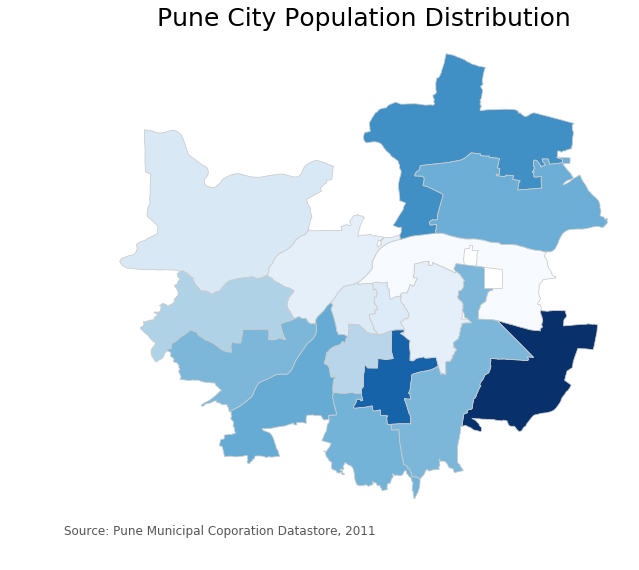

In [68]:
#column we want to visualise on the map
variable = 'Population'
# set the range for the choropleth
vmin, vmax = 0, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 9))
merged.plot(column=variable, cmap='Blues', ax=ax, linewidth=0.8, edgecolor='0.8')
ax.axis('off')
ax.axis('off')
#Title
ax.set_title('Pune City Population Distribution', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Annotation
ax.annotate('Source: Pune Municipal Coporation Datastore, 2011',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

### Segmenting and Clustering Wards in Pune

In [69]:
CLIENT_ID = 'BWGZTEQA531RHIK4GFUWI1AEWB10JFXOOHIGSCVQZCVYEJFT' # your Foursquare ID
CLIENT_SECRET = '5NZH5XVLAMLO1313KUAUSPIQM5EISKGMVTXCWO5T2RSLBGRN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            results = None
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [82]:
LIMIT = 50
Pune_venues = getNearbyVenues(names=pune_LL['Ward Name'],
                                   latitudes=pune_LL['Latitude'],
                                   longitudes=pune_LL['Longitude']
                                  )

Dhanori
Vidhyanagar Lohagaon
Tingre Pumping Station
Kalas Vishrantwadi
Nanasaheb Parulekar Vidhyalaya
Yerwada Prizen Press
Lohagaon Vimantal
Kharadigaon
Kharadi Infotech Park
Sundrabai Marathe Vidhyalaya
Vadgaon Sheri
Ramwadi
Agakhan Pallace
Don Bosco  Highschool
NagpurChawl
PhuleNagar ,Yerwada
Netaji Subhashchandra Bose Vidhyalaya
Yerwadagaon
Parnkuti
YerwadaHotmix Plant
Deccon Collage
Kamal Nayan Bajaj Udhyan
Setki Mahavidhyalaya
Sanjay Gandhi Rugnalya
Bopodi
Pune Vidhyapeeth
AundhGaon
Baner-Balewadi
Sutarwadi
Pashan
Aundh I.T.I
RajBhavan
Chaturshingi Mandir
Model Colony
Morden Collage
P.M.C Bhavan
Dr.Nayadu Hospital
Bundgarden
Wadiya Collage
Koregaon Park
Mundhvagaon
Magarpatta Hadapsar
Hadapsar Indestrial Estate
Sent Patric Town
Vikas Nagar Ghorpadi
Dr.Babasaheb Ambedkar Udhyan
Sasoon Hospital
Kamla Nehru Hospital
Juna Bazar
Kasba Ganpati
Shanivarwada
New English School(Ramanbaug)
Fergussion Collage
Dr.Homi Baba Hospital
Gokhlenagar
Vidhi Mahavidhyalaya
Shankarrao More Vidhyalaya
R

In [83]:
print(Pune_venues.shape)
Pune_venues.head()

(1083, 7)


,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dhanori,18.596759,73.896851,Reddy's,18.596037,73.895525,Indian Restaurant
1,Dhanori,18.596759,73.896851,Krushnai Dosa Point,18.596062,73.896681,Food Truck
2,Vidhyanagar Lohagaon,18.594668,73.917508,Four Points by Sheraton,18.590423,73.917115,Hotel
3,Tingre Pumping Station,18.576718,73.893968,Reddys Vadapav Center,18.574442,73.892433,Breakfast Spot
4,Tingre Pumping Station,18.576718,73.893968,Mad Momos,18.575221,73.895084,Café


Pune_venues.groupby('Ward').count()

In [86]:
print('There are {} uniques categories.'.format(len(Pune_venues['Venue Category'].unique())))

There are 137 uniques categories.


In [87]:
Pune_venues['Venue Category'].unique()

array(['Indian Restaurant', 'Food Truck', 'Hotel', 'Breakfast Spot',
       'Café', 'Fast Food Restaurant', 'Tea Room', 'Bakery',
       'Pizza Place', 'Shopping Mall', 'South Indian Restaurant',
       'Coffee Shop', 'Dessert Shop', 'Chinese Restaurant',
       'Airport Service', 'Bookstore', 'Smoke Shop', 'Airport Food Court',
       'Snack Place', 'Juice Bar', 'Airport Terminal', 'River', 'Diner',
       'Multicuisine Indian Restaurant', 'Restaurant',
       'New American Restaurant', 'Bar', 'Gym / Fitness Center',
       'Department Store', 'Ice Cream Shop', 'Print Shop', 'BBQ Joint',
       'Park', 'Thai Restaurant', 'Historic Site', 'Brewery', 'Gym',
       'Museum', 'Vegetarian / Vegan Restaurant', 'Italian Restaurant',
       'Electronics Store', 'Lounge', 'Deli / Bodega',
       'Convenience Store', 'Nightclub', 'Asian Restaurant', 'Resort',
       'Furniture / Home Store', 'Pub', 'Concert Hall', 'Golf Course',
       'Gastropub', 'Food Court', 'Donut Shop', 'Multiplex',
     

### Analysing each Ward

In [222]:
Pune_OH = pd.get_dummies(Pune_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Pune_OH['Ward'] = Pune_venues['Ward'] 

# move neighborhood column to the first column
fixed_columns = [Pune_OH.columns[-1]] + list(Pune_OH.columns[:-1])
Pune_OH = Pune_OH[fixed_columns]

#Drop all non-dining services columns
Pune_OH.drop(columns={'Shopping Mall','Airport Service', 'Bookstore', 'Smoke Shop', 'Airport Food Court',
       'Airport Terminal', 'River', 'Gym / Fitness Center',
       'Department Store', 'Ice Cream Shop', 'Print Shop', 
       'Park', 'Historic Site', 'Gym',
       'Museum',
       'Electronics Store', 'Lounge',
       'Convenience Store', 'Resort',
       'Furniture / Home Store', 'Concert Hall', 'Golf Course',
       'Multiplex',
       'Jewelry Store', 'Bus Station', 'Stationery Store',
       'Movie Theater', 'Playground', 'Cosmetics Shop', 'Farmers Market',
       'Grocery Store', 'Plaza', 'Clothing Store', 'Sporting Goods Shop',
       'Mobile Phone Shop', 'Bus Line', 'Arts & Crafts Store',
       'Scenic Lookout','Theme Park',
        'Stadium', 'Theater', 'Motorcycle Shop', 'Platform',
       'Soccer Field', 'Garden',
       'Organic Grocery',
       'Fruit & Vegetable Store', 'Dance Studio',
       'Paper / Office Supplies Store', 'Road', "Women's Store",
       'Hookah Bar', 'IT Services', 'Pool Hall',
       'Other Great Outdoors', 'Mountain', 'Badminton Court',
       'Accessories Store',
       'Bank', 'Tennis Court', 'Wine Shop', 'Track', 'Candy Store',
       'History Museum', 'Miscellaneous Shop', 'Flea Market',
       'Food & Drink Shop', "Men's Store", 'Rest Area', 'Shoe Store',
       'Indie Movie Theater',
       'Trail','Arcade', 'Pharmacy','Theme Park Ride / Attraction',
       'Health Food Store', 'Rental Car Location', 'ATM',
       'Zoo', 'Recreation Center'}, inplace=True)

Pune_OH.head()

,Ward,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,Creperie,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gourmet Shop,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Maharashtrian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Nightclub,Pizza Place,Pub,Punjabi Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,South Indian Restaurant,Southern / Soul Food Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant
0,Dhanori,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dhanori,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Vidhyanagar Lohagaon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Tingre Pumping Station,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tingre Pumping Station,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
Pune_OH.shape

(1083, 58)

#### Next, let's group rows by Ward and by taking sum of occurrence of each category

In [225]:
PuneGRP = Pune_OH.groupby('Ward').mean().reset_index()
PuneGRP.shape

(136, 58)

#### Top 5 Venues in each Ward by Frequency

In [191]:
num_top_venues = 5

for Ward in PuneGRP['Ward']:
    print("----"+Ward+"----")
    temp = PuneGRP[PuneGRP['Ward'] == Ward].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agakhan Pallace----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.07
1                           Café  0.07
2             Italian Restaurant  0.07
3                         Bakery  0.07
4           Fast Food Restaurant  0.07


----Agam Mandir Katraj----
               venue  freq
0        Coffee Shop  0.17
1               Café  0.17
2          Nightclub  0.00
3          Hotel Bar  0.00
4  Indian Restaurant  0.00


----Anandnagar -Higne Khurd----
                            venue  freq
0                    Gourmet Shop  0.25
1            Fast Food Restaurant  0.25
2                     Pizza Place  0.25
3  Multicuisine Indian Restaurant  0.00
4                           Hotel  0.00


----Aundh I.T.I----
                  venue  freq
0     Indian Restaurant  0.25
1           Snack Place  0.08
2  Fast Food Restaurant  0.08
3            Restaurant  0.08
4    Mexican Restaurant  0.08


----AundhGaon----
                  venue  freq
0     Indian Restaurant  

                venue  freq
0                Café  0.16
1              Bakery  0.16
2   Indian Restaurant  0.11
3  Italian Restaurant  0.05
4          Restaurant  0.05


----Kothrud Gaon----
               venue  freq
0  Indian Restaurant  0.18
1               Café  0.18
2     Sandwich Place  0.18
3         Restaurant  0.09
4             Bakery  0.09


----Lohagaon Vimantal----
                            venue  freq
0                     Snack Place  0.11
1                       Juice Bar  0.11
2                     Pizza Place  0.11
3             American Restaurant  0.00
4  Multicuisine Indian Restaurant  0.00


----Lohianagar----
                  venue  freq
0      Asian Restaurant   0.2
1  Fast Food Restaurant   0.2
2            Donut Shop   0.2
3   American Restaurant   0.0
4          Gourmet Shop   0.0


----Magarpatta Hadapsar----
               venue  freq
0        Coffee Shop  0.33
1          BBQ Joint  0.33
2  Indian Restaurant  0.33
3          Nightclub  0.00
4          Ho

                            venue  freq
0                       BBQ Joint   0.2
1                     Snack Place   0.2
2                      Restaurant   0.2
3             American Restaurant   0.0
4  Multicuisine Indian Restaurant   0.0


----Vadgaon Dhayari----
                     venue  freq
0         Asian Restaurant  0.17
1                     Café  0.17
2  New American Restaurant  0.00
3                    Hotel  0.00
4                Hotel Bar  0.00


----Vadgaon Sheri----
                 venue  freq
0  American Restaurant   0.0
1            Gastropub   0.0
2                Hotel   0.0
3            Hotel Bar   0.0
4    Indian Restaurant   0.0


----Ved Bhavan----
                     venue  freq
0        Indian Restaurant  0.50
1                     Café  0.33
2      American Restaurant  0.00
3  New American Restaurant  0.00
4                    Hotel  0.00


----Vidhi Mahavidhyalaya----
                     venue  freq
0                   Bakery  0.14
1        Indian Restau

#### We will now create a Dataframe of the above results

In [209]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [210]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pune_venues_sorted = pd.DataFrame(columns=columns)
pune_venues_sorted['Ward'] = PuneGRP['Ward']

for ind in np.arange(PuneGRP.shape[0]):
    pune_venues_sorted.iloc[ind, 1:] = return_most_common_venues(PuneGRP.iloc[ind, :], num_top_venues)

pune_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agakhan Pallace,Vegetarian / Vegan Restaurant,Bakery,Italian Restaurant,Café,Brewery,Fast Food Restaurant,Restaurant,Breakfast Spot,South Indian Restaurant,Thai Restaurant
1,Agam Mandir Katraj,Coffee Shop,Café,Vegetarian / Vegan Restaurant,Food Court,Food,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
2,Anandnagar -Higne Khurd,Gourmet Shop,Fast Food Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Cocktail Bar,Food,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
3,Aundh I.T.I,Indian Restaurant,Mexican Restaurant,Fast Food Restaurant,Snack Place,Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
4,AundhGaon,Indian Restaurant,Fast Food Restaurant,Restaurant,Food Court,Korean Restaurant,Chocolate Shop,Snack Place,Mexican Restaurant,Diner,Dim Sum Restaurant


### Clustering of Wards

#### Using Elbow Method to check optimal number of clusters

1 : 0.34772646064272045
2 : 0.31999339077368694
3 : 0.30576598892656354
4 : 0.2919668089891415
5 : 0.28598494161710575
6 : 0.2754805786351735
7 : 0.26877582014924395
8 : 0.26181616189948786
9 : 0.25703007051575333
10 : 0.24592424282552752
11 : 0.24139193977794385
12 : 0.2303393246231241
13 : 0.22497474852844923
14 : 0.2238610080817055


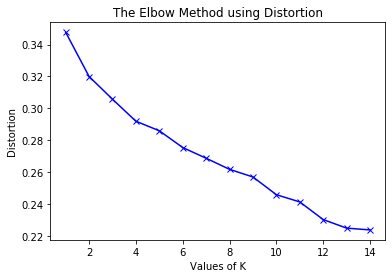

array([1, 0, 1, 3, 1, 9, 0, 3, 3, 1], dtype=int32)

In [229]:
Pune_grouped_clustering = PuneGRP.drop('Ward', 1)

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(Pune_grouped_clustering) 
    kmeanModel.fit(Pune_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(Pune_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / Pune_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(Pune_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / Pune_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

#### Distrotion decreases linearly after k=10, this is our optimal value.

In [215]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters).fit(Pune_grouped_clustering) 
kmeans.fit(Pune_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 0, 1, 3, 1, 9, 0, 3, 3, 1], dtype=int32)

In [216]:
Punemerged = pune_LL

pune_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#add Latitude and Longitude for each Ward
Punemerged = Punemerged.join(pune_venues_sorted.set_index('Ward'), on='Ward Name')

In [217]:
Punemerged = Punemerged.dropna().reset_index()

#### Visualise Clusters

In [218]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Punemerged['Latitude'], Punemerged['Longitude'], Punemerged['Ward Name'], Punemerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters